# Препроцессинг
В этом ноутбуке мы будем строить pipeline препроцессинга данных на примере одного гидропоста

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from datetime import datetime, timedelta

from rdm_helpers import get_meteo, helper_save, split_df_by, na_heat_map, interpolate_df, nse
import rdm_helpers

plt.style.use('ggplot')

Так как мы будем обучать отдельные модели для каждого гидропоста для удобства разделим подготовленные файлы по station_id

In [2]:
old_data_path = 'datasets/'
data_path = './data/hydro/'
df_names = ['daily', 'disch_d', 'ice']

In [3]:
# for df_name in df_names:
#     df = pd.read_pickle(old_data_path + "processed_data/"+ df_name + ".pkl")
#     for grp, df in split_df_by(df, 'station_id'):
#         df.to_csv(data_path + '0' + str(grp) + '_' + df_name + '.csv', index=False)

Рассмотрим станцию расположенную на зейском водохранилище

In [4]:
station_id = 6456#5024#5012

In [5]:
hydro_df = pd.read_csv(data_path + '/0' + str(station_id) + '_daily.csv', index_col = 'date', engine='python')

meteo_df, _ = get_meteo(station_id, '../datasets/')

### Данные с гидропостов

In [6]:
hydro_df

,stage_avg,stage_min,stage_max,temp,water_code,station_id
date,,,,,,
1984-01-01,440.0,440.0,440.0,NaN,16.0,6456
1984-01-02,441.0,441.0,441.0,NaN,16.0,6456
1984-01-03,440.0,440.0,440.0,NaN,16.0,6456
1984-01-04,440.0,440.0,440.0,NaN,16.0,6456
1984-01-05,440.0,440.0,440.0,NaN,16.0,6456
...,...,...,...,...,...,...
2017-12-27,360.0,360.0,360.0,NaN,46.0,6456
2017-12-28,359.0,359.0,359.0,NaN,46.0,6456
2017-12-29,355.0,355.0,355.0,NaN,46.0,6456


In [7]:
hydro_df.index = pd.to_datetime(hydro_df.index)

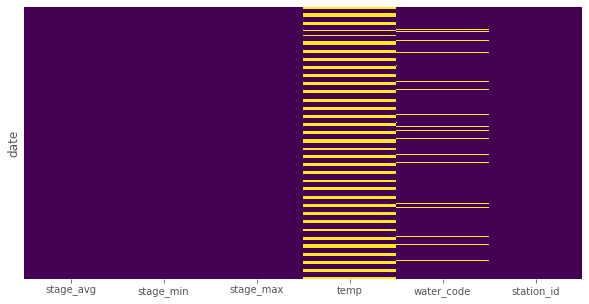

In [8]:
na_heat_map(hydro_df, figsize = (10, 5))

Интерполируем температуру воды

In [9]:
hydro_df = interpolate_df(hydro_df, cols = ['temp', 'stage_max'])

In [10]:
hydro_df['stage_delta'] = (hydro_df['stage_max'] - hydro_df['stage_min'])

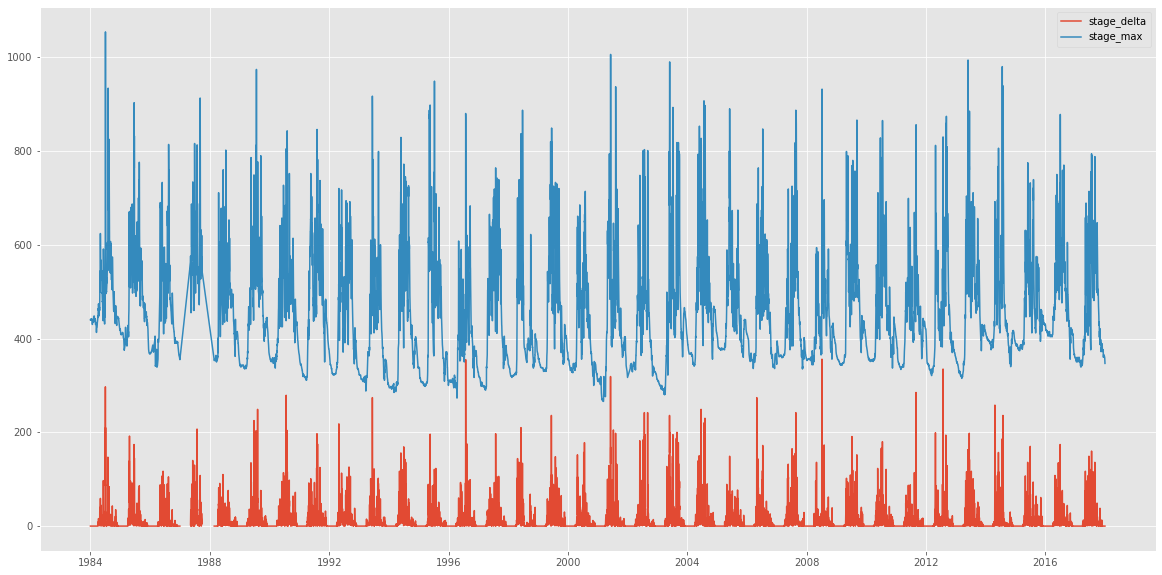

In [11]:
from rdm_helpers import plot_series
plot_series(hydro_df, cols = ['stage_delta', 'stage_max'])

In [12]:
hydro_df[hydro_df['water_code'] == 12]

,stage_avg,stage_min,stage_max,temp,water_code,station_id,stage_delta
date,,,,,,,


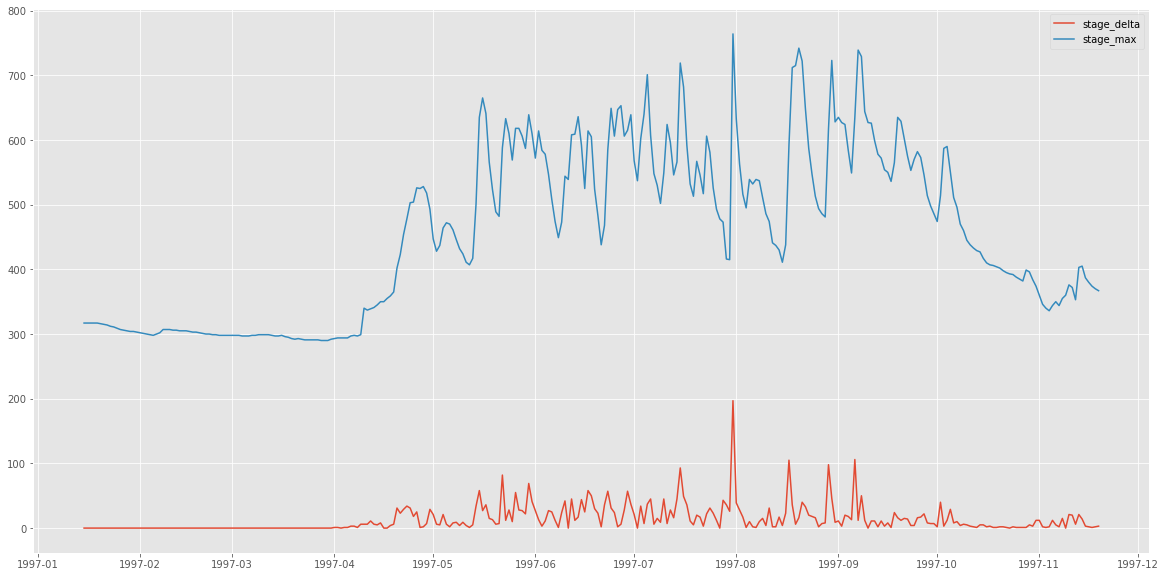

In [13]:
plot_series(hydro_df, cols = ['stage_delta', 'stage_max'], start_date = '1997-01-15', end_date = '1997-11-19')

Очевидно, что заторы влияют на уровень воды, однако это может происходить крайне редко

In [14]:
hydro_df['congestion_up'] = hydro_df['water_code'] == 11
hydro_df['congestion_down'] = hydro_df['water_code'] == 12

In [15]:
hydro_df = hydro_df.drop(['water_code', 'station_id', 'stage_min', 'stage_avg'], axis = 1)

<AxesSubplot:xlabel='date'>

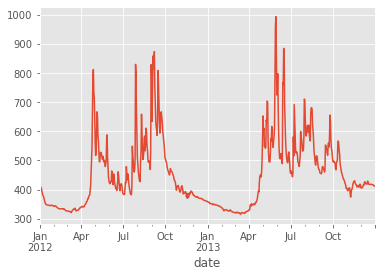

In [16]:
hydro_df['stage_max']['2012-01-01' : '2013-12-31'].plot()

In [17]:
hydro_df['doy'] = hydro_df.index.dayofyear

In [18]:
import statsmodels.api as sm

def substract_seasonality(series, period):
    return series - sm.tsa.seasonal_decompose(series, period = period).seasonal
hydro_df['seasonality'] = sm.tsa.seasonal_decompose(hydro_df['stage_max'], period = 365).seasonal
# hydro_df['seasonality']['2013-01-01':'2014-01-01'].plot()
# hydro_df['stage_max'] = substract_seasonality(hydro_df['stage_max'], 365)

In [19]:
#hydro_df[''] = pd.read_csv(data_path + '/0' + str(station_id) + '_daily.csv', index_col = 'date', engine='python')

## Метео

In [20]:
meteo_df

,station_name,station_id,visibility_distance,visibility_distance_quality,wind_direction,wind_direction_quality,wind_speed_avg,wind_speed_avg_quality,wind_speed_sign,wind_speed_max,wind_speed_max_quality,wind_speed_max_sign,precipitation_amount,precipitation_amount_quality,temperature_ground,temperature_ground_quality,temperature_air,temperature_air_quality,humidity,humidity_quality
time,,,,,,,,,,,,,,,,,,,,
2013-04-17 21:00:00,CHEGDOM,5123301,99.0,0,0,0,0,0,NaN,0.0,0,NaN,0.0,0,-7.3,0,-5.0,0,98,0
2013-04-17 18:00:00,CHEGDOM,5123301,NaN,5,0,0,0,0,NaN,0.0,0,NaN,NaN,5,-11.3,0,-5.2,0,96,0
2013-04-17 15:00:00,CHEGDOM,5123301,NaN,5,0,0,0,0,NaN,1.0,0,NaN,NaN,5,-9.5,0,-4.0,0,87,0
2013-04-17 12:00:00,CHEGDOM,5123301,NaN,5,0,0,0,0,NaN,1.0,0,NaN,NaN,5,-5.7,0,-1.9,0,78,0
2013-04-17 09:00:00,CHEGDOM,5123301,99.0,0,22,0,4,0,NaN,5.0,0,NaN,0.0,0,-1.0,0,2.4,0,62,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2000-05-31 21:00:00,CHEGDOM,5123301,97.0,0,130,0,1,0,NaN,2.0,0,NaN,0.0,0,4.5,0,4.7,0,92,0
2000-05-31 00:00:00,CHEGDOM,5123301,99.0,0,270,0,1,0,NaN,3.0,0,NaN,NaN,5,19.5,0,11.3,0,71,0
2000-05-31 03:00:00,CHEGDOM,5123301,99.0,0,220,0,2,0,NaN,4.0,0,NaN,NaN,5,30.6,0,17.2,0,48,0


In [21]:
meteo_df.index = pd.to_datetime(meteo_df.index)

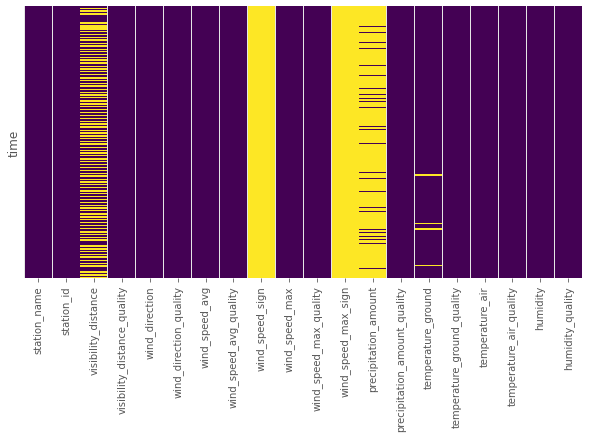

In [22]:
na_heat_map(meteo_df, figsize = (10, 5))

In [23]:
variebles = ['humidity', 'temperature_air', 'temperature_ground', 'precipitation_amount', 'wind_speed_max', 'wind_direction']
for var in variebles:
    meteo_df.loc[meteo_df[var + '_quality'] > 2, var] = np.nan

<AxesSubplot:xlabel='time'>

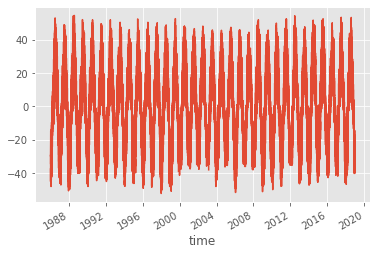

In [24]:
meteo_df['temperature_ground']['1985-01-01': '2019-01-04'].plot()

In [25]:
meteo_df['hour'] = list(map(lambda x: x.hour, meteo_df.index.time))

In [26]:
meteo_df = meteo_df.resample('D')\
.agg({
    'precipitation_amount': 'sum',
    'temperature_air': 'mean',
    'temperature_ground': 'mean',
    'humidity': 'mean'
})

In [27]:
disch_df = pd.read_csv(data_path + '0' + str(station_id) + '_disch_d.csv', engine='python')
disch_df.dropna()

,date,consumption,station_id
0,1984-01-01,21.5,6456
1,1984-01-02,21.0,6456
2,1984-01-03,20.6,6456
3,1984-01-04,20.1,6456
4,1984-01-05,19.7,6456
...,...,...,...
10385,2013-12-26,41.6,6456
10386,2013-12-27,40.8,6456
10387,2013-12-28,40.1,6456
10388,2013-12-29,39.4,6456


<AxesSubplot:>

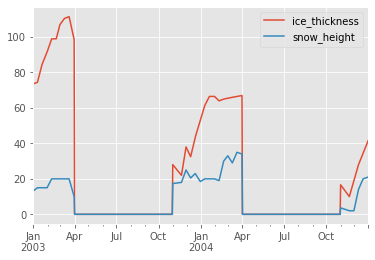

In [28]:
ice_df = pd.read_csv(data_path + '/0' + str(station_id) + '_ice.csv', index_col = 'date', engine='python')

pd.set_option('display.max_row', 1000)

idx = pd.date_range('1984-01-01', '2019-01-04')
#ice_df.loc[~((ice_df.index.month < 4) | (ice_df.index.month > 10))]# , ['ice_thickness', 'snow_height']] = 0
ice_df = ice_df.groupby('date').mean()

ice_df.index = pd.DatetimeIndex(ice_df.index)
ice_df = ice_df.drop(["place", 'station_id'], axis=1)
ice_df = ice_df.reindex(idx, fill_value=np.nan)
ice_df = interpolate_df(ice_df, cols = ['ice_thickness', 'snow_height'])
# na_heat_map(ice_df['2000-04':'2000-11'])
ice_df.loc[ice_df.index.month.isin(range(4, 11))] = 0
ice_df.loc[ice_df.index.year.isin(range(2003, 2005))].plot()

In [29]:
back = 30
period = 270

ice_df[['snow_height_ma','ice_thickness_ma']] = ice_df[['snow_height','ice_thickness']].shift(back).rolling(period).sum()
#ice_df[['snow_height_df','ice_thickness_df']] = ice_df[['snow_height','ice_thickness']].shift(1).rolling(2).apply(lambda x: x[1] - x[0]).shift(120).rolling(240)

ice_df = ice_df[['snow_height_ma','ice_thickness_ma']]

In [30]:
#meteo_df['humidity'] = meteo_df['humidity'].shift(7).rolling(10).sum()
meteo_df['humidity'] = meteo_df['humidity'].shift(7).rolling(10).sum()
# hydro_df['stage_max_ma_1'] = hydro_df['stage_max'].shift(1).rolling(3).mean()
hydro_df['stage_max_ma_2'] = hydro_df['stage_max'].rolling(2).apply(lambda x: x[1] - x[0])

In [31]:
hydro_df['stage_max_ma_2']

date
1984-01-01    NaN
1984-01-02    1.0
1984-01-03   -1.0
1984-01-04    0.0
1984-01-05    0.0
             ... 
2017-12-27    0.0
2017-12-28   -1.0
2017-12-29   -4.0
2017-12-30   -5.0
2017-12-31   -3.0
Name: stage_max_ma_2, Length: 12145, dtype: float64

In [32]:
meteo_df = interpolate_df(meteo_df, cols = ['temperature_ground', 'humidity'])

In [33]:
meteo_df.index.rename('date', inplace=True)

In [34]:
def extract_seasonality(series, period):
    return sm.tsa.seasonal_decompose(series, period = period).seasonal
# meteo_df['temperature_ground'] = substract_seasonality(meteo_df['temperature_ground'], 365)
# meteo_df['temperature_ground'].plot()

In [35]:
# up_stations = [6323, 6299, 6265, 6302, 6319]
# up_stations_df = []
# for i in up_stations:
#     up_stations_df.append(pd.read_csv(data_path + '/0' + str(i) + '_daily.csv', index_col = 'date', engine='python'))

# for (i, d) in enumerate(up_stations_df):
#     d.index = pd.to_datetime(d.index)

#     d = interpolate_df(d, cols = ['stage_max'])
#     hydro_df['prev_' + str(i)] = d['stage_max']

In [36]:
idf = ice_df[['snow_height_ma','ice_thickness_ma']].copy()

In [37]:
df = pd.concat([hydro_df, meteo_df.reindex(hydro_df.index), ice_df.reindex(hydro_df.index)], axis = 1)
#df['month'] = df.index.month
pd.set_option('display.max_colwidth', 100)

Baseline

In [38]:
from rdm_helpers import TimeSeriesExtracter
df = TimeSeriesExtracter(['stage_delta', 'temp','precipitation_amount', 'temperature_ground', 'stage_max'],# 'humidity'], #+ ['prev_' + str(i) for i in range(4)],
                    [0,0,0,0,0],
                    [4,4,10,8,10]).fit_transform(df)
lag = 5
df['stage_max'] = df['stage_max'].shift(-lag)
df['doy'] = df['doy'].shift(-lag)
df['seasonality'] = df['seasonality'].shift(-lag)
df['humidity'] = df['humidity'].shift(-max(7, lag))
df['ice_thickness_ma'] = df['ice_thickness_ma'].shift(-lag)
df['snow_height_ma'] = df['snow_height_ma'].shift(-lag)

In [39]:
df = df['1987-01-01':]

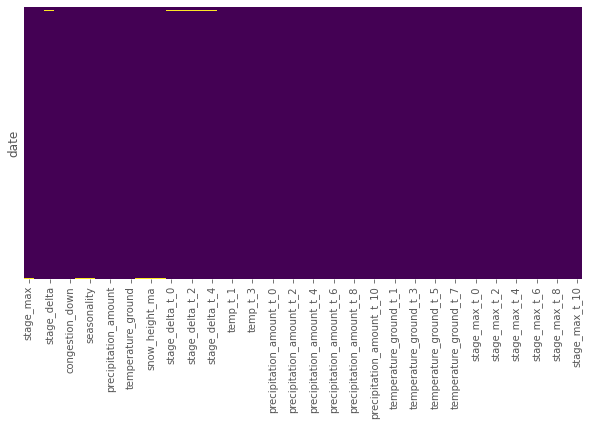

In [40]:
na_heat_map(df['1987-01-01':], figsize = (10, 5))

In [41]:
random_state = 228
label_name = 'stage_max'

In [42]:
from sklearn.model_selection import train_test_split
train_end = '2016-12-31'
test_start = '2017-01-01'
test_end = '2017-12-21'

X = df.drop(['temp', 'stage_delta', 'precipitation_amount', 'temperature_ground', 'temperature_air', 'congestion_up', 'congestion_down', label_name], axis = 1)
Y = df[label_name]

X_train, X_test, y_train, y_test = X[:train_end], X[test_start:test_end], Y[:train_end], Y[test_start:test_end] #train_test_split(df.drop([label_name], axis = 1), df[label_name], train_size=0.75, random_state=random_state)

In [43]:
X.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 11049 entries, 1987-05-01 to 2017-12-31
Data columns (total 47 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   doy                        11044 non-null  float64
 1   seasonality                11044 non-null  float64
 2   stage_max_ma_2             11049 non-null  float64
 3   humidity                   11042 non-null  float64
 4   snow_height_ma             11044 non-null  float64
 5   ice_thickness_ma           11044 non-null  float64
 6   stage_delta_t_0            11017 non-null  float64
 7   stage_delta_t_1            11017 non-null  float64
 8   stage_delta_t_2            11017 non-null  float64
 9   stage_delta_t_3            11017 non-null  float64
 10  stage_delta_t_4            11017 non-null  float64
 11  temp_t_0                   11049 non-null  float64
 12  temp_t_1                   11049 non-null  float64
 13  temp_t_2                   11

In [44]:
import lightgbm as lgb

def custom_RMSE(y_true, y_pred):
    squared_residual = 2 * (y_pred - y_true)
    grad = squared_residual
    hess = np.ones(len(y_true))
    return grad, hess

parameters = {     
#     'task': 'train',
#     'boosting_type': 'gbdt',
     'objective': 'rmse',
     'random_state': 42,
     'metric': ['l2', 'mae', 'mse'],
     'drop_rate':0.5,
     'learning_rate': 0.004,
     'feature_fraction': 0.8,
     'bagging_fraction': 0.4,
#     'bagging_freq': 10,
     "n_estimators":1500,
     "max_depth": 8,
     "num_leaves": 32,  
     "max_bin": 64,
     #"n_jobs": 4,
     "random_state": random_state,
     "early_stopping_rounds":100,
    
}
train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test)

model = lgb.LGBMRegressor() 

model.set_params(**parameters, metrics = ["mse", 'mae'])

model.fit(
    X_train,
    y_train,
    eval_set=[(X_test, y_test)],
#     random_state = random_state,
    verbose=True,
)

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4
[LightGBM] [Warning] early_stopping_round is set=100, early_stopping_rounds=100 will be ignored. Current value: early_stopping_round=100
[1]	valid_0's l2: 12682.5	valid_0's l1: 92.2562
Training until validation scores don't improve for 100 rounds
[2]	valid_0's l2: 12618.7	valid_0's l1: 91.9801
[3]	valid_0's l2: 12553.1	valid_0's l1: 91.7137
[4]	valid_0's l2: 12493.2	valid_0's l1: 91.4547
[5]	valid_0's l2: 12433.3	valid_0's l1: 91.2041
[6]	valid_0's l2: 12371.6	valid_0's l1: 90.9413
[7]	valid_0's l2: 12310	valid_0's l1: 90.6677
[8]	valid_0's l2: 12251.8	valid_0's l1: 90.413
[9]	valid_0's l2: 12194.6	valid_0's l1: 90.1593
[10]	valid_0's l2: 12132.6	valid_0's l1: 89.9021
[11]	valid_0's l2: 12073.4	valid_0's l1: 89.6472
[12]	valid_0's l2: 12017.5	valid_

C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[31]	valid_0's l2: 11021.1	valid_0's l1: 84.8504
[32]	valid_0's l2: 10973	valid_0's l1: 84.6301
[33]	valid_0's l2: 10923.5	valid_0's l1: 84.3899
[34]	valid_0's l2: 10876.6	valid_0's l1: 84.1689
[35]	valid_0's l2: 10829.4	valid_0's l1: 83.945
[36]	valid_0's l2: 10782.8	valid_0's l1: 83.7266
[37]	valid_0's l2: 10735.9	valid_0's l1: 83.5046
[38]	valid_0's l2: 10690.4	valid_0's l1: 83.2829
[39]	valid_0's l2: 10644.3	valid_0's l1: 83.0675
[40]	valid_0's l2: 10598.4	valid_0's l1: 82.8458
[41]	valid_0's l2: 10552.1	valid_0's l1: 82.6297
[42]	valid_0's l2: 10507.3	valid_0's l1: 82.4134
[43]	valid_0's l2: 10461.1	valid_0's l1: 82.1942
[44]	valid_0's l2: 10417.6	valid_0's l1: 81.9799
[45]	valid_0's l2: 10374	valid_0's l1: 81.768
[46]	valid_0's l2: 10330.5	valid_0's l1: 81.5574
[47]	valid_0's l2: 10286.8	valid_0's l1: 81.3468
[48]	valid_0's l2: 10244.1	valid_0's l1: 81.1358
[49]	valid_0's l2: 10201.2	valid_0's l1: 80.9247
[50]	valid_0's l2: 10158.3	valid_0's l1: 80.7109
[51]	valid_0's l2: 10116.8

LGBMRegressor(bagging_fraction=0.4, drop_rate=0.5, early_stopping_rounds=100,
              feature_fraction=0.8, learning_rate=0.004, max_bin=64,
              max_depth=8, metric=['l2', 'mae', 'mse'], metrics=['mse', 'mae'],
              n_estimators=1500, num_leaves=32, objective='rmse',
              random_state=228)

In [45]:
from sklearn.metrics import mean_absolute_error as mae
predict = model.predict(X_test)
true = y_test.values
print(mae(true, predict))
print(nse(true, predict))

40.21146356499221
0.3791095822783772


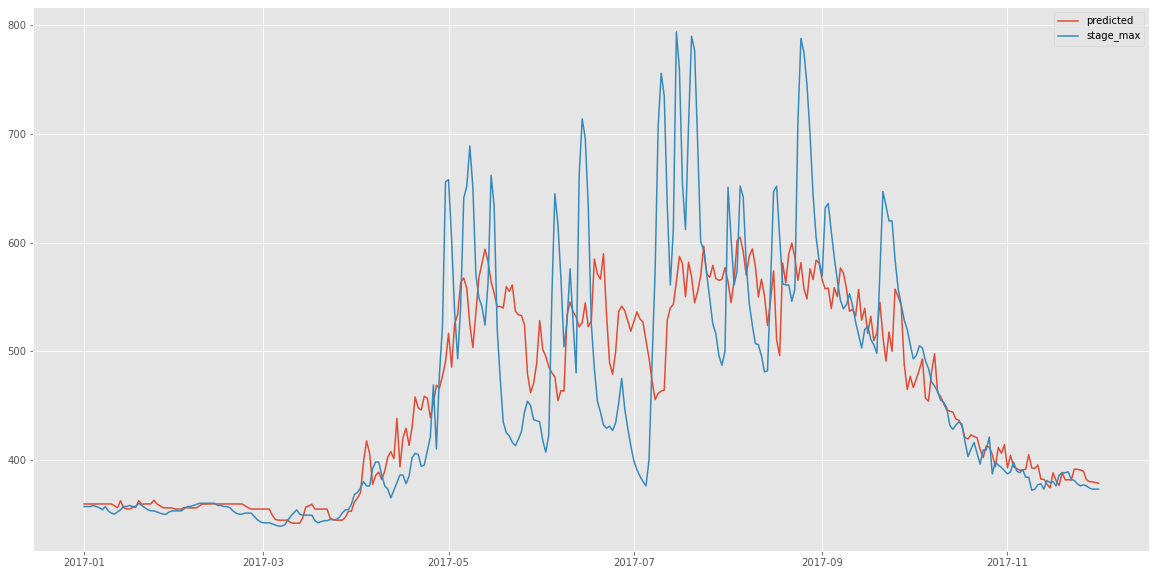

In [46]:
res = pd.DataFrame(y_test.copy())
res['predicted'] = predict
plot_series(res['2017-01-01':"2017-12-01"], cols = ['predicted', 'stage_max'])

In [47]:
# def step_forecast(model, var_prefix, x, n, d):
#     x_ = x.copy()
#     predictions = []
#     for i in range(n):
#         prediction = model.predict(x_)
#         predictions.append(prediction)
#         if i != n - 1:
#             for k in range(2, d + 1, -1):
#                 x_[var_prefix + str(k)] = x_[var_prefix + str(k - 1)] 
#             x_[var_prefix + '10'] = prediction
#     return np.stack(predictions, axis=0)

In [48]:
# forecast = step_forecast(model, 'stage_max_t_', X_test, 10, 20)

In [49]:
import shap
X_importance = X_train
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_importance)

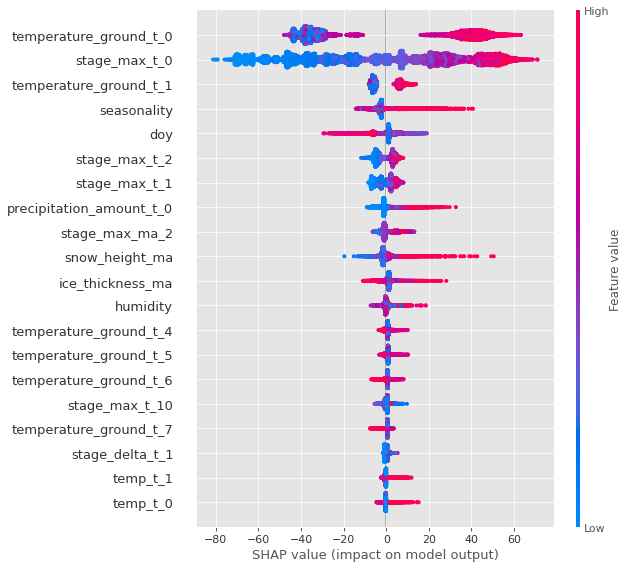

In [50]:
shap.summary_plot(shap_values, X_importance)